[Quora- Question Pairs](https://www.kaggle.com/c/quora-question-pairs)

In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc




In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

%matplotlib inline

pal = sns.color_palette()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [4]:
!ls ../data/quora_question_pair/

README.md  test.csv  test.csv.zip  train.csv  train.csv.zip


In [5]:
DATA_DIR = "../data/quora_question_pair/"

In [12]:

print('# File sizes')
for f in os.listdir(DATA_DIR):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize(DATA_DIR + f) / 1000000, 2)) + 'MB')

# File sizes
test.csv                      314.02MB
train.csv                     63.4MB
README.md                     0.0MB


It's worth noting that there is a lot more testing data than training data. 

# Training Data

In [47]:
df_train = pd.read_csv(DATA_DIR+ '/train.csv')
df_train['question1'] = df_train['question1'].astype(str)
df_train['question2'] = df_train['question2'].astype(str)
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


We are given a minimal number of data fields here, consisting of:

**id** : Looks like a simple rowID  
**qid{1, 2}** : The unique ID of each question in the pair  
**question{1, 2}** : The actual textual contents of the questions.  
**is_duplicate** : The label that we are trying to predict - whether the two questions are duplicates of each other.  

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780



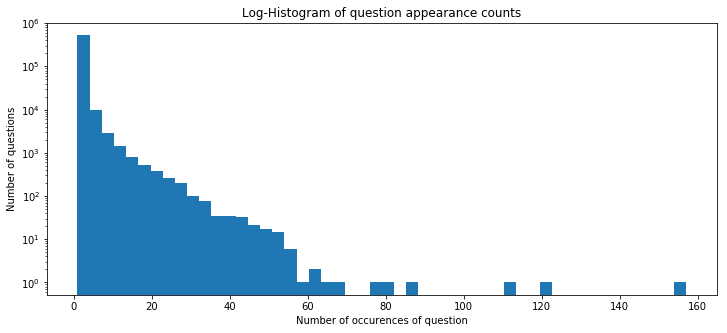

In [16]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))

qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(np.unique(qids))))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

In terms of questions, everything looks as I would expect here. Most questions only appear a few times, with very few questions appearing several times (and a few questions appearing many times). One question appears more than 160 times, but this is an outlier.

We can see that we have a 37% positive class in this dataset. Since we are using the LogLoss metric, and LogLoss looks at the actual predicts as opposed to the order of predictions, we should be able to get a decent score by creating a submission predicting the mean value of the label.

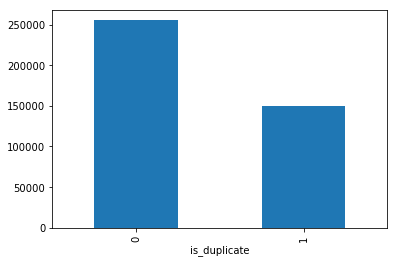

In [30]:
df_train.groupby("is_duplicate")['id'].count().plot.bar()

### Log Loss
$$log P(y_t|y_p) = y_t log(y_p) + (1 - y_t) log(1 - y_p)$$

# Test Set

In [18]:
df_test = pd.read_csv(DATA_DIR+ '/test.csv')
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [19]:
print('Total number of question pairs for testing: {}'.format(len(df_test)))

Total number of question pairs for testing: 2345796


# Text analysis

First off, some quick histograms to understand what we're looking at. Most analysis here will be only on the training set, to avoid the auto-generated questions

mean-train 59.82 std-train 31.96 mean-test 60.07 std-test 31.62 max-train 1169.00 max-test 1176.00


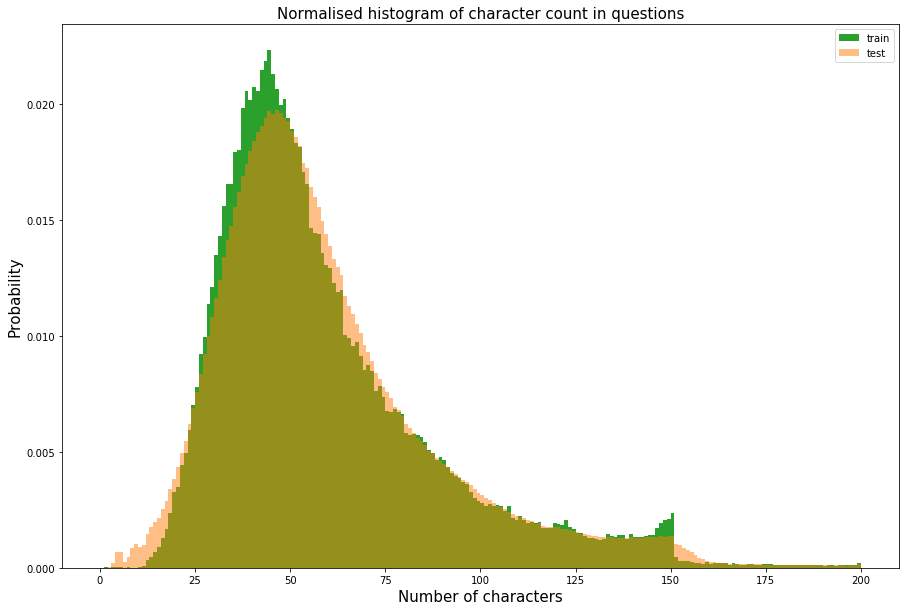

In [22]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

We can see that most questions have anywhere from 15 to 150 characters in them. It seems that the test distribution is a little different from the train one, but not too much so (I can't tell if it is just the larger data reducing noise, but it also seems like the distribution is a lot smoother in the test set).

One thing that catches my eye is the steep cut-off at 150 characters for the training set, for most questions, while the test set slowly decreases after 150. Could this be some sort of Quora question size limit?

It's also worth noting that I've truncated this histogram at 200 characters, and that the max of the distribution is at just under 1200 characters for both sets - although samples with over 200 characters are very rare.

Let's do the same for word count. I'll be using a naive method for splitting words (splitting on spaces instead of using a serious tokenizer), although this should still give us a good idea of the distribution.

mean-train 11.06 std-train 5.89 mean-test 11.02 std-test 5.84 max-train 237.00 max-test 238.00


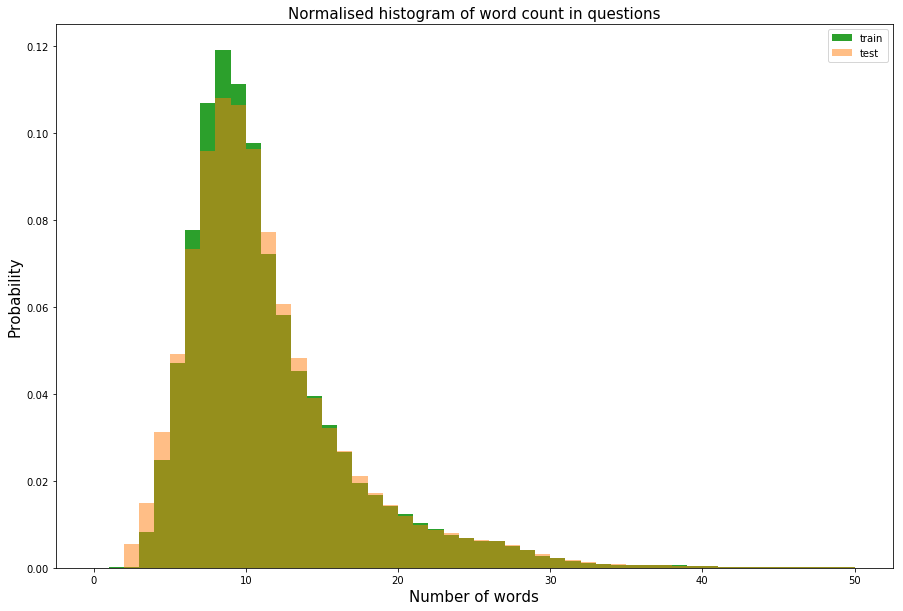

In [24]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

We see a similar distribution for word count, with most questions being about 10 words long. It looks to me like the distribution of the training set seems more "pointy", while on the test set it is wider. Nevertheless, they are quite similar.

So what are the most common words? Let's take a look at a word cloud.

(-0.5, 1439.5, 1079.5, -0.5)

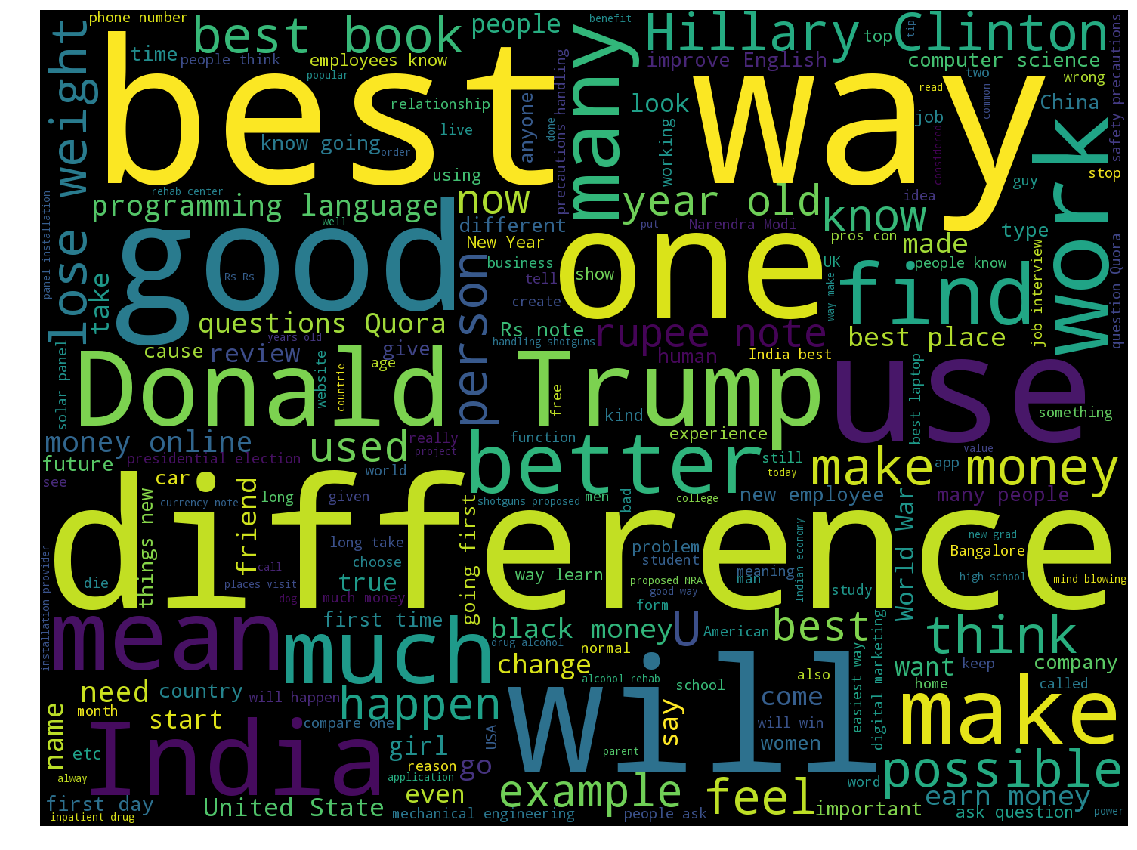

In [25]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

## Semantic Analysis
Next, I will take a look at usage of different punctuation in questions - this may form a basis for some interesting features later on.

In [26]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


## Initial Feature Analysis
Before we create a model, we should take a look at how powerful some features are. I will start off with the word share feature from the benchmark model.

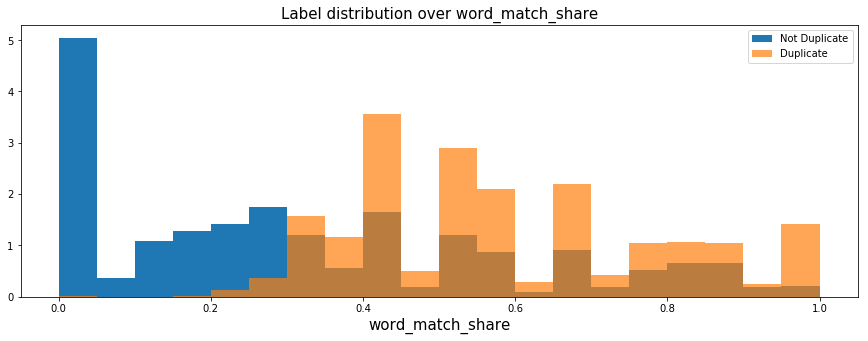

In [28]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)


Here we can see that this feature has quite a lot of predictive power, as it is good at separating the duplicate questions from the non-duplicate ones. Interestingly, it seems very good at identifying questions which are definitely different, but is not so great at finding questions which are definitely duplicates.



# Meta Features

We will now construct a basic set of features that we will later use to embed our samples with.

The first we will be looking at is rather standard TF-IDF encoding for each of the questions. In order to limit the computational complexity and storage requirements we will only encode the top terms across all documents with TF-IDF and also look at a subsample of the data.

In [31]:
df_tran_sampled = df_train[0:2500]

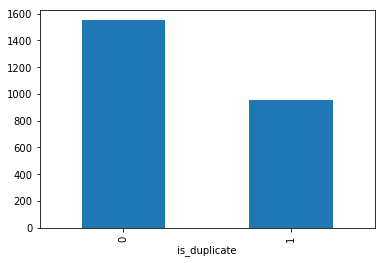

In [33]:
df_tran_sampled.groupby("is_duplicate")['id'].count().plot.bar()

The subsample still has a very similar label distribution, ok to continue like that, without taking a deeper look how to achieve better sampling than just taking the first rows of the dataset.

Create a dataframe where the top 50% of rows have only question 1 and the bottom 50% have only question 2, same ordering per halve as in the original dataframe.

In [35]:
dfq1, dfq2 = df_tran_sampled[['qid1', 'question1']], df_tran_sampled[['qid2', 'question2']]
dfq1.columns = ['qid1', 'question']
dfq2.columns = ['qid2', 'question']
# merge two two dfs, there are two nans for question
dfqa = pd.concat((dfq1, dfq2), axis=0).fillna("")
nrows_for_q1 = dfqa.shape[0]/2
dfqa.shape

(5000, 3)

Transform questions by TF-IDF.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
mq1 = TfidfVectorizer(max_features = 256).fit_transform(dfqa['question'].values)
mq1

<5000x256 sparse matrix of type '<class 'numpy.float64'>'
	with 31365 stored elements in Compressed Sparse Row format>

Since we are looking at pairs of data, we will be taking the difference of all question one and question two pairs with this. This will result in a matrix that again has the same number of rows as the subsampled data and one vector that describes the relationship between the two questions.

In [37]:
diff_encodings = np.abs(mq1[::2] - mq1[1::2])
diff_encodings

<2500x256 sparse matrix of type '<class 'numpy.float64'>'
	with 29265 stored elements in Compressed Sparse Row format>

### 3D t-SNE embedding
We will use t-SNE to embed the TF-IDF vectors in three dimensions and create an interactive scatter plot with them.

In [38]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=200,
    verbose=2,
    angle=0.5
).fit_transform(diff_encodings.toarray())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.466567
[t-SNE] Iteration 25: error = 1.6904477, gradient norm = 0.0103142
[t-SNE] Iteration 50: error = 1.6138078, gradient norm = 0.0104772
[t-SNE] Iteration 75: error = 1.3103828, gradient norm = 0.0031830
[t-SNE] Iteration 100: error = 1.2546983, gradient norm = 0.0045287
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.254698
[t-SNE] Iteration 125: error = 1.1571782, gradient norm = 0.0009612
[t-SNE] Iteration 125: gradient norm 0.000961. Finished.
[t-SNE] Error after 125 iterations: 1.254698


In [43]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = df_tran_sampled['is_duplicate'].values,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='test')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

That three dimensional embedding looks nice, but is not telling us much about the structure of the space that we created. There seem to be no clusters of either class present, so let's go on to the next section.

Let us now construct a few features

- character length of questions 1 and 2
- number of words in question 1 and 2
- normalized word share count.

We can then have a look at how well each of these separate the two classes.

In [45]:
df_train

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57.0,14
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88.0,8
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59.0,14
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65.0,11
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39.0,13
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,86,90.0,16
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,19,62.0,4
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,30,41.0,7
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,31,37.0,8
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,60,49.0,9


In [48]:
df_train['q1len'] = df_train['question1'].str.len()
df_train['q2len'] = df_train['question2'].str.len()

df_train['q1_n_words'] = df_train['question1'].apply(lambda row: len(row.split(" ")))
df_train['q2_n_words'] = df_train['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))


df_train['word_share'] = df_train.apply(normalized_word_share, axis=1)

df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,0.100000


The distributions for normalized word share have some overlap on the far right hand side, meaning there are quite a lot of questions with high word similarity but are both duplicates and non-duplicates.

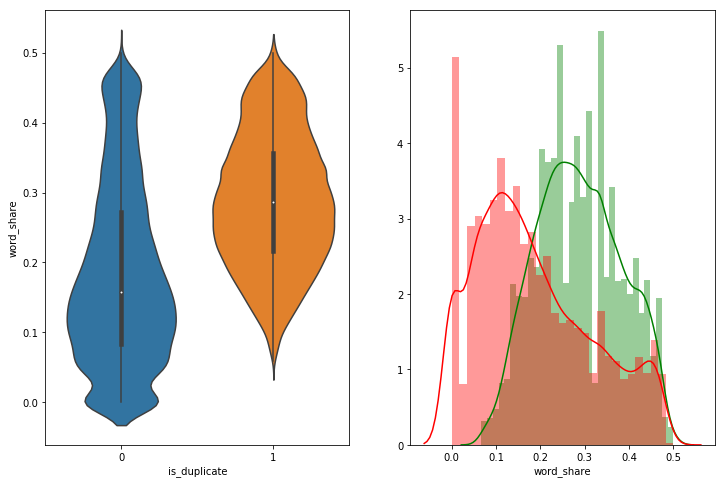

In [50]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df_train[0:50000])
plt.subplot(1,2,2)
sns.distplot(df_train[df_train['is_duplicate'] == 1.0]['word_share'][0:10000], color = 'green')
sns.distplot(df_train[df_train['is_duplicate'] == 0.0]['word_share'][0:10000], color = 'red')

Scatter plot of question pair character lengths where color indicates duplicates and the size the word share coefficient we've calculated earlier.

In [51]:
df_subsampled = df_train[0:2000]

trace = go.Scatter(
    y = df_subsampled['q2len'].values,
    x = df_subsampled['q1len'].values,
    mode='markers',
    marker=dict(
        size= df_subsampled['word_share'].values * 60,
        color = df_subsampled['is_duplicate'].values,
        colorscale='Portland',
        showscale=True,
        opacity=0.5,
        colorbar = dict(title = 'duplicate')
    ),
    text = np.round(df_subsampled['word_share'].values, decimals=2)
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Scatter plot of character lengths of question one and two',
    hovermode= 'closest',
        xaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    yaxis=dict(
        title= 'Question 2 length',
        ticklen= 5,
        gridwidth= 2,
        showgrid=False,
        zeroline=False,
        showline=False,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatterWords')

### Animation over average number of words
For that we will calculate the average number of words in both questions for each row.

In the end we want to have a scatter plot, just like the one above, but giving us one more dimension, in that case the average number of words in both questions. That will allow us to see the dependence on that variable. We also expect that as the number of words is increased, the character lengths of Q1 and Q2 will increase.

In [52]:
from IPython.display import display, HTML

df_subsampled['q_n_words_avg'] = np.round((df_subsampled['q1_n_words'] + df_subsampled['q2_n_words'])/2.0).astype(int)
print(df_subsampled['q_n_words_avg'].max())
df_subsampled = df_subsampled[df_subsampled['q_n_words_avg'] < 20]
df_subsampled.head()

39


/home/mageswarand/anaconda3/envs/tensorflow1.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share,q_n_words_avg
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,0.434783,13
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,0.200000,10
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,0.166667,12
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.000000,10
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,0.100000,10


In [53]:
word_lens = sorted(list(df_subsampled['q_n_words_avg'].unique()))
# make figure
figure = {
    'data': [],
    'layout': {
        'title': 'Scatter plot of char lenghts of Q1 and Q2 (size ~ word share similarity)',
    },
    'frames': []#,
    #'config': {'scrollzoom': True}
}

# fill in most of layout
figure['layout']['xaxis'] = {'range': [0, 200], 'title': 'Q1 length'}
figure['layout']['yaxis'] = {
    'range': [0, 200],
    'title': 'Q2 length'#,
    #'type': 'log'
}
figure['layout']['hovermode'] = 'closest'

figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 300, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Avg. number of words in both questions:',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

# make data
word_len = word_lens[0]
dff = df_subsampled[df_subsampled['q_n_words_avg'] == word_len]
data_dict = {
    'x': list(dff['q1len']),
    'y': list(dff['q2len']),
    'mode': 'markers',
    'text': list(dff['is_duplicate']),
    'marker': {
        'sizemode': 'area',
        #'sizeref': 200000,
        'colorscale': 'Portland',
        'size': dff['word_share'].values * 120,
        'color': dff['is_duplicate'].values,
        'colorbar': dict(title = 'duplicate')
    },
    'name': 'some name'
}
figure['data'].append(data_dict)

# make frames
for word_len in word_lens:
    frame = {'data': [], 'name': str(word_len)}
    dff = df_subsampled[df_subsampled['q_n_words_avg'] == word_len]

    data_dict = {
        'x': list(dff['q1len']),
        'y': list(dff['q2len']),
        'mode': 'markers',
        'text': list(dff['is_duplicate']),
        'marker': {
            'sizemode': 'area',
            #'sizeref': 200000,
            'size': dff['word_share'].values * 120,
            'colorscale': 'Portland',
            'color': dff['is_duplicate'].values,
            'colorbar': dict(title = 'duplicate')
        },
        'name': 'some name'
    }
    frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [word_len],
        {
            'frame': {'duration': 300, 'redraw': False},
            'mode': 'immediate',
            'transition': {'duration': 300}
        }
     ],
     'label': word_len,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)

    
figure['layout']['sliders'] = [sliders_dict]

py.iplot(figure)

What is interesting about that, is that as the number of words increases, the distribution of character lengths of the first and second question becomes less and less spherical.

### Embedding with engineered features
We will now revisit the t-SNE embedding with the manually engineered features.

For that we use the number of words in both questions, character lengths and their word share coefficient. t-SNE is sensitive to scaling of different dimensions and we want all of the dimensions to contribute equally to the distance measure that t-SNE is trying to preserve.

In [56]:
from sklearn.preprocessing import MinMaxScaler

df_subsampled = df_train[0:3000]
X = MinMaxScaler().fit_transform(df_subsampled[['q1_n_words', 'q1len', 'q2_n_words', 'q2len', 'word_share']])
y = df_subsampled['is_duplicate'].values

# TODO

https://www.slideshare.net/abhishekkrthakur/is-that-a-duplicate-quora-question

# Refernces:
- https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
- https://www.kaggle.com/philschmidt/quora-eda-model-selection-roc-pr-plots
- https://www.kaggle.com/sudalairajkumar/simple-leaky-exploration-notebook-quora